# CSCI 6920 - Homework 4
Name: Ohad Nir;
Due: 10/21/2022

## Problem Statement 
What makes a review positive or negative? Usually, it is a specific combination of words with their own meaning, said in a particular order with a positive or negative connotation. This task, also known as sentiment analysis, can be used in many different applications. One is classifying the sentiment of a review. In this notebook, I'll be using the IMDB movie review dataset to classify good and bad reviews.

The dataset I used is the [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) from Kaggel.

## Setup

In [196]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence

from nltk.corpus import stopwords

from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix, roc_auc_score

from pkg_resources import packaging
import clip

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000
pd.options.mode.chained_assignment = None

## Task 1

### Data Processing:

Read data:

In [197]:
imdb_df = pd.read_csv("..\\data\\IMDB_dataset.csv")
seed = 1

In [198]:
imdb_df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Lets looks at some sample reviews.

In [199]:
for i in range(3):
    print(imdb_df["review"][i], "\n")

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

Encode dataset labels.

In [200]:
le = LabelEncoder()
le.fit(imdb_df["sentiment"].unique())
imdb_df["sentiment"] = le.transform(imdb_df["sentiment"])

Data clearning.

In [201]:
stop_w = set(stopwords.words('english'))

# make all characters lowercase.
imdb_df["review"] = imdb_df["review"].str.lower()
# remove html tags.
imdb_df["review"] = imdb_df["review"].str.replace(r"<[^<>]*>", "", regex=True)
# remove all non alphanumeric except spaces.
imdb_df["review"] = imdb_df["review"].str.replace('[^A-z0-9 ]', '', regex=True) 
# remove stopwords.
imdb_df["review"] = imdb_df["review"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_w]))

Lets looks the clearned sample reviews.

In [202]:
for i in range(3):
    print(imdb_df["review"][i], "\n")

one reviewers mentioned watching 1 oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awayi would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered middle c

Class frequency:

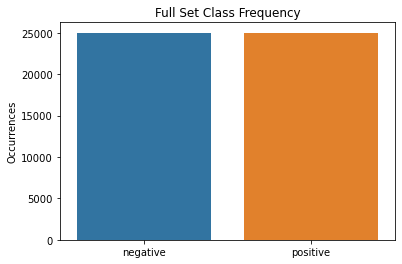

In [203]:
sns.barplot(x=['negative','positive'], y=imdb_df["sentiment"].value_counts().values)
plt.ylabel("Occurrences")
plt.title("Full Set Class Frequency")
plt.show()

The classes are balanced. Next split data on train/validation/test with stratification.

In [204]:
train_df, test_df = train_test_split(imdb_df, train_size=0.70, shuffle=True, stratify=imdb_df["sentiment"], random_state=seed)
test_df, valid_df = train_test_split(test_df, train_size=0.65, shuffle=True, stratify=test_df["sentiment"], random_state=seed)

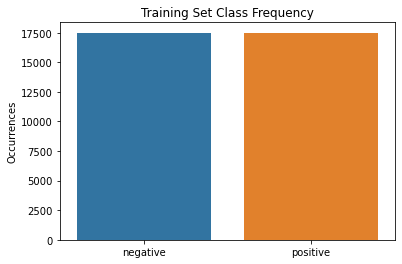

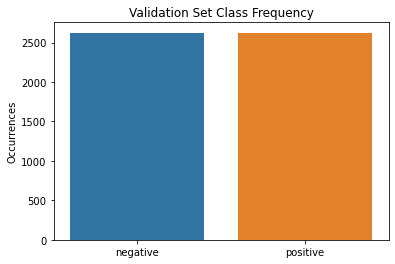

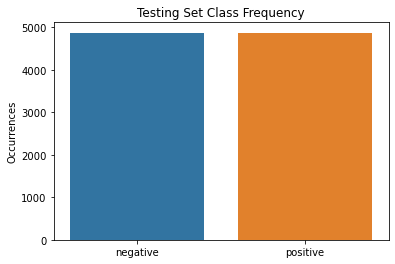

In [205]:
sns.barplot(x=['negative','positive'], y=train_df["sentiment"].value_counts().values)
plt.ylabel("Occurrences")
plt.title("Training Set Class Frequency")
plt.show()

sns.barplot(x=['negative','positive'], y=valid_df["sentiment"].value_counts().values)
plt.ylabel("Occurrences")
plt.title("Validation Set Class Frequency")
plt.show()

sns.barplot(x=['negative','positive'], y=test_df["sentiment"].value_counts().values)
plt.ylabel("Occurrences")
plt.title("Testing Set Class Frequency")
plt.show()

Tokenize and create vocabulary on the training set.

In [206]:
def string_to_token(X, tokenizer):
    for x in X:
        yield tokenizer(x)

tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(string_to_token(train_df["review"], tokenizer), min_freq=3, specials=['<unk>', '<pad>'])
vocab.set_default_index(vocab["<unk>"])
padding_idx = vocab["<pad>"]

text_pipeline = lambda x: vocab(tokenizer(x))

Vectorize the reviews.

In [207]:
train_df["review_vec"] = train_df["review"].apply(lambda r: text_pipeline(r))
train_df["rv_length"] = train_df["review_vec"].apply(lambda r: len(r))

valid_df["review_vec"] = valid_df["review"].apply(lambda r: text_pipeline(r))
valid_df["rv_length"] = valid_df["review_vec"].apply(lambda r: len(r))

test_df["review_vec"] = test_df["review"].apply(lambda r: text_pipeline(r))
test_df["rv_length"] = test_df["review_vec"].apply(lambda r: len(r))

To decide on the size of the sequence lets evaluate the training set sequence length.

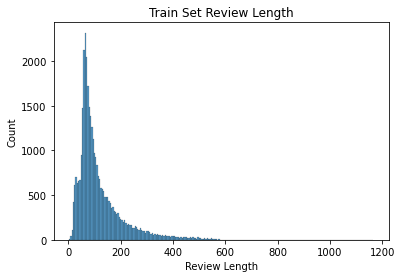

In [208]:
sns.histplot(train_df["rv_length"])
plt.xlabel("Review Length")
plt.title("Train Set Review Length")
plt.show()

Most of the reviews are under 600 tokens in length.

In [209]:
max_length=600

We will pre-pad reviews that have less than 600 tokens with the special padding token assgined when vocabulary was created. If sequence is longer than 600 tokens then we will truncate the review.

In [210]:
# Padding
train_df["review_vec"] = train_df["review_vec"].apply(lambda r: [padding_idx for _ in range(max_length-len(r))] + r)
valid_df["review_vec"] = valid_df["review_vec"].apply(lambda r: [padding_idx for _ in range(max_length-len(r))] + r)
test_df["review_vec"] = test_df["review_vec"].apply(lambda r: [padding_idx for _ in range(max_length-len(r))] + r)

# Truncating
train_df["review_vec"] = train_df["review_vec"].apply(lambda r: r[:max_length])
valid_df["review_vec"] = valid_df["review_vec"].apply(lambda r: r[:max_length])
test_df["review_vec"] = test_df["review_vec"].apply(lambda r: r[:max_length])

In [211]:
X_train, y_train = np.array([l for l in train_df["review_vec"]]), np.array(train_df["sentiment"])
X_valid, y_valid = np.array([l for l in valid_df["review_vec"]]), np.array(valid_df["sentiment"])
X_test, y_test = np.array([l for l in train_df["review_vec"]]), np.array(train_df["sentiment"])

In [243]:
class SequentialModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_size, num_layers, output_size, padding_idx, drop_rate=0, bidirectional=False, mode="RNN"):
        super(SequentialModel, self).__init__()
                        
        if mode == "RNN":
            self.recurrent = nn.RNN(embedding_dim, hidden_size, num_layers, bidirectional=bidirectional)
        elif mode == "LSTM":
            self.recurrent = nn.LSTM(embedding_dim, hidden_size, num_layers, bidirectional=bidirectional)
        elif mode == "GRU":
            self.recurrent = nn.GRU(embedding_dim, hidden_size, num_layers, bidirectional=bidirectional)
        else:
            raise ValueException(f"Mode must be either 'RNN', 'LSTM', or 'GRU' but was {mode}.")
            
        self.embedding = nn.EmbeddingBag(num_embeddings, embedding_dim, padding_idx=padding_idx)
        self.dropout = nn.Dropout(drop_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        self.activ = nn.Sigmoid()
        
    def forward(self, X):
        embedded = self.embedding(X)
        o_recurrent, hidden = self.recurrent(embedded)
        o_dropout = self.dropout(o_recurrent)
        output = self.activ(self.fc(o_dropout))
        
        return output.flatten()
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)
    

def fit(model, criterion, optimizer, epochs, data, progress=True):
    train_generator, valid_generator = data
    
    history = {
                "train_loss": [],
                "validation_loss": [],
                "train_accuracy": [],
                "validation_accuracy": []
    }
    
    for e in range(epochs):
        model.train()
        
        if progress:
            print("Epoch:", e+1)
            train_loader = tqdm(train_generator)
            train_loader.set_description(desc=f"Training loss: {np.NAN}")
        else:
            train_loader = train_generator
            
        loss = 0
        for i, (X, y) in enumerate(train_loader):

            y_hat = model(X)
            batch_loss = criterion(y_hat.float(), y.float())
            loss += batch_loss.item()
        
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            
            if progress:
                train_loader.set_description(desc=f"Training loss: {loss/(i+1)}")
        
        train_eval = evaluate(model, criterion, train_generator)
        valid_eval = evaluate(model, criterion, valid_generator)
        
        history["train_loss"].append(train_eval[0])
        history["validation_loss"].append(valid_eval[0])
        history["train_accuracy"].append(train_eval[1])
        history["validation_accuracy"].append(valid_eval[1])
        
        if progress:
            print(f"Train loss: {train_eval[0]} | Train Accuracy: {train_eval[1]} || Validation loss: {valid_eval[0]} | Validation Accuracy: {valid_eval[1]}")
            
    return history

def evaluate(model, criterion, data_loader):
    model.eval()
    
    loss = 0
    acc = 0
    
    for X, y in data_loader:
        y_hat = model(X)
        loss += float(criterion(y_hat.float(), y.float()))
        y_hat = (y_hat > 0.5).int()
        
        acc += float(torch.sum(y == y_hat))
    
    loss /= len(data_loader)
    acc /= len(data_loader.dataset)

    return (loss, acc)
    
def toDataloader(X, y, batch_size, shuffle, collate_fn=None):
    X_T = torch.Tensor(X).to(torch.int64)
    y_T = torch.Tensor(y).type(torch.int64)
    
    dataset = torch.utils.data.TensorDataset(X_T, y_T)
    
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle, collate_fn=collate_fn)

def plot_train_hist(history, epochs):
    plt.plot(history["train_loss"], label="Training Loss")
    plt.plot(history["validation_loss"], label="Validation Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks(range(0, epochs, 4))
    plt.show()

    plt.plot(history["train_accuracy"], label="Training Accuracy")
    plt.plot(history["validation_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.xticks(range(0, epochs, 4))
    plt.show()
    
def predict(model, X):
    model.eval()
    y_hat = model(torch.Tensor(X).to(torch.int64))
    y_pred = (y_hat.detach().numpy() > 0.5)
    return y_pred

def auc(model, y_true, y_pred):
    return roc_auc_score(y_true, y_pred, multi_class="ovr")
    
def accuracy(model, criterion, dataloader, y_true, y_pred, dset):
    _, acc = evaluate(model, criterion, dataloader)
    
    cm = confusion_matrix(y_true, y_pred)
    train_fnr = cm[1,0]/(cm[1,0]+cm[1,1])
    sns.heatmap(cm, 
                xticklabels=le.classes_, 
                yticklabels=le.classes_, 
                annot=True)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{dset} Set Confusion Matrix")
    plt.show()
    
    return acc


Model hyper perameters:

In [213]:
batch_size = 256
epochs = 5
learning_rate = 0.001
regularization = 0

vocab_size = len(vocab)
embedding_dim = 300
hidden_size = 10
num_layers = 1
output_size = 1
drop_rate = 0.5

In [214]:
train_dataloader = toDataloader(X_train, y_train, batch_size, True)
valid_dataloader = toDataloader(X_valid, y_valid, batch_size, True)
test_dataloader = toDataloader(X_test, y_test, batch_size, False)

### RNN Model:

In [194]:
sentiment_classifier_rnn = SequentialModel(vocab_size,
                                  embedding_dim, 
                                  hidden_size, 
                                  num_layers, 
                                  output_size, 
                                  padding_idx, 
                                  drop_rate=drop_rate, 
                                  bidirectional=False, 
                                  mode="RNN")
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(sentiment_classifier_rnn.parameters(), lr=learning_rate, weight_decay=regularization)

history = fit(sentiment_classifier_rnn, criterion, optimizer, epochs, (train_dataloader, valid_dataloader))

Epoch: 1


  0%|          | 0/137 [00:00<?, ?it/s]

Train loss: 0.5442232855045013 | Train Accuracy: 0.7809714285714285 || Validation loss: 0.5518337403024945 | Validation Accuracy: 0.7742857142857142
Epoch: 2


  0%|          | 0/137 [00:00<?, ?it/s]

Train loss: 0.3305834035803802 | Train Accuracy: 0.8750285714285714 || Validation loss: 0.35929111213911147 | Validation Accuracy: 0.8558095238095238
Epoch: 3


  0%|          | 0/137 [00:00<?, ?it/s]

Train loss: 0.23744183648241698 | Train Accuracy: 0.9138285714285714 || Validation loss: 0.2919567269938333 | Validation Accuracy: 0.8813333333333333
Epoch: 4


  0%|          | 0/137 [00:00<?, ?it/s]

Train loss: 0.1820596335795674 | Train Accuracy: 0.9381714285714285 || Validation loss: 0.26874440837474095 | Validation Accuracy: 0.896
Epoch: 5


  0%|          | 0/137 [00:00<?, ?it/s]

Train loss: 0.14329109346344523 | Train Accuracy: 0.9557714285714286 || Validation loss: 0.26269496977329254 | Validation Accuracy: 0.8971428571428571


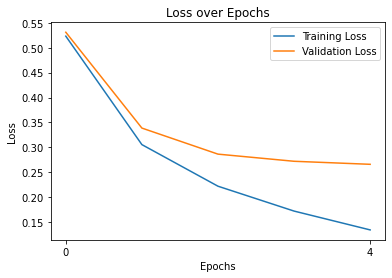

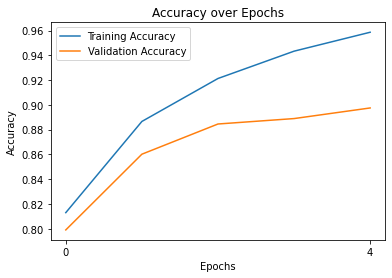

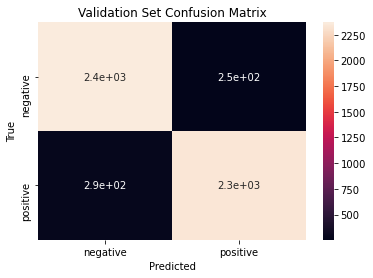

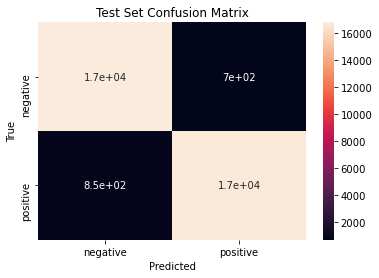

RNN model achived a AUC score of 0.8971 and 0.9558 on the validation and test data and a accuracy of 0.8971 and 0.9558 on the validation and test data.


In [253]:
plot_train_hist(history, epochs)

y_pred = predict(sentiment_classifier_rnn, X_valid)
rnn_valid_auc = auc(sentiment_classifier_rnn, y_valid, y_pred)
rnn_valid_acc = accuracy(sentiment_classifier_rnn, criterion, valid_dataloader, y_valid, y_pred, dset="Validation")

y_pred = predict(sentiment_classifier_rnn, X_test)
rnn_test_auc = auc(sentiment_classifier_rnn, y_test, y_pred)
rnn_test_acc = accuracy(sentiment_classifier_rnn, criterion, test_dataloader, y_test, y_pred, dset="Test")

print(f"RNN model achived a AUC score of {rnn_valid_auc:.4f} and {rnn_test_auc:.4f} on the validation and test data and a accuracy of {rnn_valid_acc:.4f} and {rnn_test_acc:.4f} on the validation and test data.")

### LSTM Model:

In [246]:
sentiment_classifier_lstm = SequentialModel(vocab_size,
                                  embedding_dim, 
                                  hidden_size, 
                                  num_layers, 
                                  output_size, 
                                  padding_idx, 
                                  drop_rate=drop_rate, 
                                  bidirectional=False, 
                                  mode="LSTM")
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(sentiment_classifier_lstm.parameters(), lr=learning_rate, weight_decay=regularization)

history = fit(sentiment_classifier_lstm, criterion, optimizer, epochs, (train_dataloader, valid_dataloader))

Epoch: 1


  0%|          | 0/137 [00:00<?, ?it/s]

Train loss: 0.5619614485406528 | Train Accuracy: 0.8075428571428571 || Validation loss: 0.5668533132189796 | Validation Accuracy: 0.7973333333333333
Epoch: 2


  0%|          | 0/137 [00:00<?, ?it/s]

Train loss: 0.31195802149111335 | Train Accuracy: 0.8911428571428571 || Validation loss: 0.34577857454617816 | Validation Accuracy: 0.8664761904761905
Epoch: 3


  0%|          | 0/137 [00:00<?, ?it/s]

Train loss: 0.22453387136006878 | Train Accuracy: 0.9228857142857143 || Validation loss: 0.28967641648792086 | Validation Accuracy: 0.8855238095238095
Epoch: 4


  0%|          | 0/137 [00:00<?, ?it/s]

Train loss: 0.17184672325196929 | Train Accuracy: 0.9452285714285714 || Validation loss: 0.2730555413734345 | Validation Accuracy: 0.894095238095238
Epoch: 5


  0%|          | 0/137 [00:00<?, ?it/s]

Train loss: 0.13425603682977438 | Train Accuracy: 0.9598285714285715 || Validation loss: 0.2674512437411717 | Validation Accuracy: 0.8986666666666666


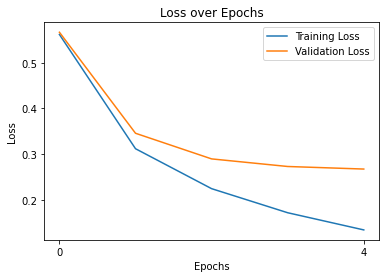

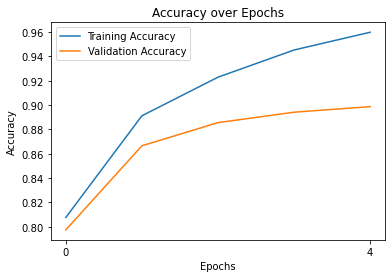

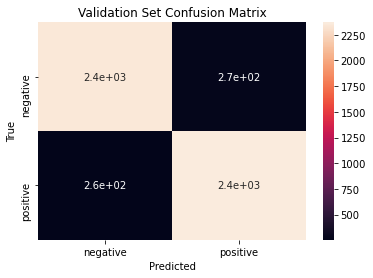

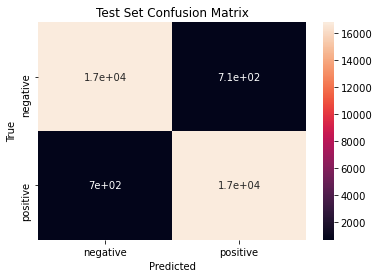

LSTM model achived a AUC score of 0.8996 and 0.9598 on the validation and test data and a accuracy of 0.8973 and 0.9598 on the validation and test data.


In [249]:
plot_train_hist(history, epochs)

y_pred = predict(sentiment_classifier_lstm, X_valid)
lstm_valid_auc = auc(sentiment_classifier_lstm, y_valid, y_pred)
lstm_valid_acc = accuracy(sentiment_classifier_lstm, criterion, valid_dataloader, y_valid, y_pred, dset="Validation")

y_pred = predict(sentiment_classifier_lstm, X_test)
lstm_test_auc = auc(sentiment_classifier_lstm, y_test, y_pred)
lstm_test_acc = accuracy(sentiment_classifier_lstm, criterion, test_dataloader, y_test, y_pred, dset="Test")

print(f"LSTM model achived a AUC score of {lstm_valid_auc:.4f} and {lstm_test_auc:.4f} on the validation and test data and a accuracy of {lstm_valid_acc:.4f} and {lstm_test_acc:.4f} on the validation and test data.")

### GRU Model:

In [250]:
sentiment_classifier_gru = SequentialModel(vocab_size,
                                  embedding_dim, 
                                  hidden_size, 
                                  num_layers, 
                                  output_size, 
                                  padding_idx, 
                                  drop_rate=drop_rate, 
                                  bidirectional=False, 
                                  mode="GRU")
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(sentiment_classifier_gru.parameters(), lr=learning_rate, weight_decay=regularization)

history = fit(sentiment_classifier_gru, criterion, optimizer, epochs, (train_dataloader, valid_dataloader))

Epoch: 1


  0%|          | 0/137 [00:00<?, ?it/s]

Train loss: 0.5232031412803344 | Train Accuracy: 0.813 || Validation loss: 0.5310693525132679 | Validation Accuracy: 0.799047619047619
Epoch: 2


  0%|          | 0/137 [00:00<?, ?it/s]

Train loss: 0.3054061465672333 | Train Accuracy: 0.8866285714285714 || Validation loss: 0.33863633161499385 | Validation Accuracy: 0.8601904761904762
Epoch: 3


  0%|          | 0/137 [00:00<?, ?it/s]

Train loss: 0.22187123213806292 | Train Accuracy: 0.9213142857142858 || Validation loss: 0.2862868961833772 | Validation Accuracy: 0.8845714285714286
Epoch: 4


  0%|          | 0/137 [00:00<?, ?it/s]

Train loss: 0.1719268517446344 | Train Accuracy: 0.9433714285714285 || Validation loss: 0.27194248068900334 | Validation Accuracy: 0.8889523809523809
Epoch: 5


  0%|          | 0/137 [00:00<?, ?it/s]

Train loss: 0.13410147535104822 | Train Accuracy: 0.9586571428571429 || Validation loss: 0.26585470352854046 | Validation Accuracy: 0.8975238095238095


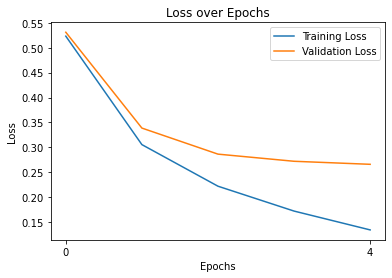

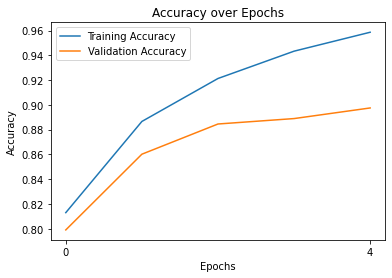

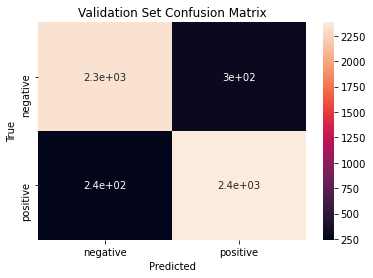

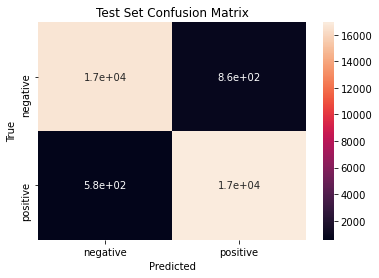

GRU model achived a AUC score of 0.8970 and 0.9591 on the validation and test data and a accuracy of 0.8964 and 0.9591 on the validation and test data.


In [256]:
plot_train_hist(history, epochs)

y_pred = predict(sentiment_classifier_gru, X_valid)
gru_valid_auc = auc(sentiment_classifier_gru, y_valid, y_pred)
gru_valid_acc = accuracy(sentiment_classifier_gru, criterion, valid_dataloader, y_valid, y_pred, dset="Validation")

y_pred = predict(sentiment_classifier_gru, X_test)
gru_test_auc = auc(sentiment_classifier_gru, y_test, y_pred)
gru_test_acc = accuracy(sentiment_classifier_gru, criterion, test_dataloader, y_test, y_pred, dset="Test")

print(f"GRU model achived a AUC score of {gru_valid_auc:.4f} and {gru_test_auc:.4f} on the validation and test data and a accuracy of {gru_valid_acc:.4f} and {gru_test_acc:.4f} on the validation and test data.")

### Model Differences:
The three models performed very similary on both the validation and testing data. This lack of oberved differences could a product of this dataset not being very complext and thus the added components in LSTM and GRU are not nessesary for achiving good accuracy and generalizability. 

LSTM and GRU attempt to manage the vanishing gradient problem of RNN's by adding a memory gate that decide on which information can be forgotten meaning that only important information is maintained and amplified. Since the perfomance of these optimizations is similar to the basic RNN model makes me think that we are not running into a valishing gradient problem with this dataset.

### Other Approach:
You can use a traditional feed-forward network to solve the problem of IMBD sentiment analysis. Still, it's unlikely to perform as well as it won't have a spacial syntax that gives language contextual meaning.

## Task 2

In [257]:
model, _ = clip.load("ViT-B/32")
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [258]:
def compare_words(model, word1, word2):
    model.eval()
    
    word1_token = clip.tokenize(word1)
    word2_token = clip.tokenize(word2)
    
    with torch.no_grad():
        word1_features = model.encode_text(word1_token).float()
        word2_features = model.encode_text(word2_token).float()
        
    cs = float(cosine_similarity(word1_features, word2_features)[0][0])
    ds = float(dissimilarity(word1_features, word2_features))
    return (cs, ds)
    
def cosine_similarity(encoding1, encoding2):
    return encoding1 @ encoding2.T / (torch.norm(encoding1, p=2) * torch.norm(encoding2, p=2))

def dissimilarity(encoding1, encoding2):
    return torch.norm(encoding1-encoding2, p=2)

In [259]:
word1 = input("First word: ")
word2 = input("Second word: ")
cos_sim, dis_sim = compare_words(model, word1, word2)
print(f"Words '{word1}' and '{word2}' have a costine similairty of {cos_sim:.4f} and a dissimilarity of {dis_sim:.4f}")

First word:  apple
Second word:  fruit


Words 'apple' and 'fruit' have a costine similairty of 0.8353 and a dissimilarity of 5.8893


For my dissimilarity I used difference of squares using the l2 norm. First I subtract one encoded word vector from the other and then take the Euclidean distance of that difference vector. This tells us how far the two word vectors are, so the larger the result the more dissimiler the two words are.